# Compute the Condition Number of a Matrix
This notebook contains code that will compute the conditon number of a matrix using the 1-norm.

Author: Jennefer Maldonado

Date Due: September 22, 2020

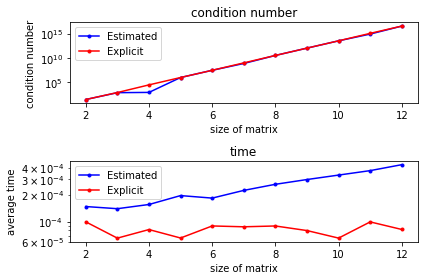

In [3]:
#import statements
from time import time
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt


def cond1(A):
    # Estimating the condition number of a real matrix A using 1-norm
    # input : matrix A
    # output : LU factorization (L,U,P), Condition number (k)
    n = np.size(A, axis=0)

    ## TODO Implement this function

    # (1) Find 1-norm of A /
    a_norm = np.linalg.norm(A, 1)

    # (2) Estimate 1-norm of inv(A) => |z|_1/|y|_1 /
    P, L, U = scipy.linalg.lu(A)

    # (2a) Find v s.t U^(t)v = c
    v = np.zeros((n, 1))
    c = np.ones((n, 1))
    U_trans = np.transpose(U)
    
    # Calculate v using forwards substitution
    # At each step, choose the component of c {1 or -1} that makes v larger in
    # magnitude
    # first step to avoid negative index error
    v1 = -1/U_trans[0,0]
    v2 = 1/U_trans[0,0]
    if v1 > v2: #deciding if c is pos or negative and setting v to the correct value
        c[0] = -1
        v[0] = v1
    else:
        c[0] = 1
        v[0] = v2
    #go through the rest of the 1-n elements
    for i in range(1,n):
        cpos = 1
        cneg = -1
        for j in range(1,i-1):
            cpos = cpos - U_trans[i,j]*v[j]
            cneg = cneg - U_trans[i,j]*v[j]
        if cpos > cneg: # which v is greater becomes the v(i)
            c[i] = 1
            v[i] = cpos/U_trans[i,i]
        else:
            c[i] = -1
            v[i] = cneg/U_trans[i,i]
        
    # (2b) Compute y s.t L^(t)Py = v
    p_times_y = scipy.linalg.solve_triangular(L.transpose(), v)
    y = P.transpose() * p_times_y
    
    # (2c) Find z s.t Az = y
    L_times_z = scipy.linalg.solve_triangular(U,P.transpose()*y)
    z = scipy.linalg.solve_triangular(L, L_times_z)
    
    # (2d) Calculate the 1norm of inv(A)
    z_norm = np.linalg.norm(z, 1)
    y_norm = np.linalg.norm(y,1)
    
    #estimate the 1 norm of A^-1
    ainv_norm = z_norm/y_norm
    
    # (3) Compute the estimated condition number of A
    condition_number = a_norm * ainv_norm
    return condition_number


# Template for estimating the condition number of Hilbert matrices
def hw2_6(N=12):
    # size of mat
    ns = np.array(range(2, N + 1))

    # k1 : cond. number from estimation, k2 : cond. number from using LU
    k1 = np.zeros(np.size(ns))
    k2 = np.zeros(np.size(ns))

    # time array
    # total : to compute average time
    time1 = np.zeros(np.size(ns))
    total1 = np.zeros(np.size(ns))
    time2 = np.zeros(np.size(ns))
    total2 = np.zeros(np.size(ns))

    # Iteration
    it = 500

    for _t in range(it):
        for p in range(np.size(ns)):
            # Compute the Hilbert matrix
            H = np.zeros((ns[p], ns[p]))
            for i in range(ns[p]):
                for j in range(ns[p]):
                    H[i, j] = 1 / (i + j + 1)

            time0 = time()
            # estimated condition number
            k1[p] = cond1(H)
            time1[p] = time()

            # condition number by computing inv(A) explicitly
            P, L, U = scipy.linalg.lu(H)
            invH = np.matmul(np.matmul(np.linalg.inv(U), np.linalg.inv(L)),
                             P.transpose())
            k2[p] = np.linalg.norm(H, 1) * np.linalg.norm(invH, 1)

            time2[p] = time() - time1[p]
            time1[p] -= time0

            total1[p] = total1[p] + time1[p]
            total2[p] = total2[p] + time2[p]

    total1 /= it
    total2 /= it

    # comparing condition number (y-axis scaled by log)
    plt.subplot(211)
    plt.semilogy(ns, k1, 'b.-', label = 'Estimated')
    plt.semilogy(ns, k2, 'r.-', label = 'Explicit')
    plt.title('condition number')
    plt.xlabel('size of matrix')
    plt.ylabel('condition number')
    plt.legend()

    # comparing time
    plt.subplot(212)
    plt.semilogy(ns, total1, 'b.-', label = 'Estimated')
    plt.semilogy(ns, total2, 'r.-', label = 'Explicit')
    plt.title('time')
    plt.xlabel('size of matrix')
    plt.ylabel('average time')
    plt.legend()

    plt.tight_layout()

    plt.savefig('output_figure')


hw2_6()

### Analysis
The required flops for the explicit computation is $\frac{8}{3}n^3$, where as the handwritten function would need significantly more than that at around $n^2$ for the two for loops. But, the explicit computation requires so many less steps unlike the estimation where transpose, multiplication, and loops are needed. Despite the analysis I did it seems to take significantly longer for the estimated computation which I presume is because of the extra steps to estimate $A^{-1}$. The condition numbers are pretty similar but the timing is important to consider. Both seem to be pretty accurate in finding the condition number with the only dip at matrix size 4.